# **Assignment 7** 

1. Check this Repo out: https://github.com/kuangliu/pytorch-cifar 
2. You are going to follow the same structure for your Code from now on. So Create:
    - models folder - this is where you'll add all of your future models. Copy resnet.py into this folder, this file should only have ResNet 18/34 models. Delete Bottleneck Class
    - main.py - from Google Colab, now onwards, this is the file that you'll import (along with the model). Your main file shall be able to take these params or you should be able to pull functions from it and then perform operations, like (including but not limited to):
      - training and test loops
      - data split between test and train
      - epochs
      - batch size
      - which optimizer to run
      - do we run a scheduler?
    - utils.py file (or a folder later on when it expands) - this is where you will add all of your utilities like:
      -image transforms,
      - gradcam,
      - misclassification code,
      - tensorboard related stuff
      - advanced training policies, etc
      - etc
3. Name this main repos something, and don't call it Assignment 7. This is what you'll import for all the rest of the assignments. Add a proper readme describing all the files. 
4. Your assignment is to build the above training structure. Train ResNet18 on Cifar10 for 20 Epochs. The assignment must:
  - pull your Github code to google colab (don't copy-paste code)
  - prove that you are following the above structure
  - that the code in your google collab notebook is NOTHING.. barely anything.  
  - There should not be any function or class that you can define in your Google Colab Notebook. Everything must be imported from all of your other files
  - your colab file must:
    - train resnet18 for 20 epochs on the CIFAR10 dataset
    - show loss curves for test and train datasets
    - show a gallery of 10 misclassified images
    - show gradcam Links to an external site.output on 10 misclassified images. **Remember if you are applying GradCAM on a channel that is less than 5px, then please don't bother to submit the assignment.** 😡🤬🤬🤬🤬
  - Once done, upload the code to GitHub, and share the code. This readme must link to the main repo so we can read your file structure. 
  - Train for 20 epochs
  - Get 10 misclassified images
  - Get 10 GradCam outputs on any misclassified images (remember that you MUST use the library we discussed in the class)
  - Apply these transforms while training:
    - RandomCrop(32, padding=4)
    - CutOut(16x16)
5. Assignment Submission Questions:
  - Share the COMPLETE code of your model.py
  - Share the COMPLETE code of your utils.py
  - Share the COMPLETE code of your main.py
  - Copy-paste the training log (cannot be ugly)
  - Copy-paste the 10/20 Misclassified Images Gallery
  - Copy-paste the 10/20 GradCam outputs Gallery
  - Share the link to your MAIN repo
  - Share the link to your README of Assignment 7 (cannot be in the MAIN Repo, but Assignment 8 repo)

In [1]:
!export PYTORCH_CUDA_ALLOC_CONF=garbage_collection_threshold:0.6,max_split_size_mb:128
!rm -rf ./*
!git clone https://github.com/abhyuditjain/pytorch-models
!mv pytorch-models/* ./
!rm -rf pytorch-models
!pip install -r requirements.txt

Cloning into 'pytorch-models'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 87 (delta 50), reused 63 (delta 26), pack-reused 0
Unpacking objects: 100% (87/87), 28.64 KiB | 1.24 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=6f9daf7488dafbae165f04e901e72628f0f1b07d8314bd6b815ff5af8d974aba
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [2]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn as nn
from utils.dataloader import Cifar10DataLoader
from models import ResNet18
from utils.trainer import Trainer
from utils.tester import Tester
from utils.summary import print_summary
from utils.utils import show_misclassified_images, show_training_images, denormalize, show_grad_cam, show_losses_and_accuracies, get_module_by_name, get_device
from main import get_train_runner, get_test_runner, train_model

In [3]:
is_cuda_available, device = get_device()

model = ResNet18().to(device=device)

print_summary(model, device, input_size=(3, 32, 32))

Layer (type (var_name))                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
ResNet (ResNet)                          --                        [20, 3, 32, 32]           [20, 10]                  --                        --                        True
├─Conv2d (conv1)                         [3, 3]                    [20, 3, 32, 32]           [20, 64, 32, 32]          1,728                     35,389,440                True
├─BatchNorm2d (bn1)                      --                        [20, 64, 32, 32]          [20, 64, 32, 32]          128                       2,560                     True
├─Sequential (layer1)                    --                        [20, 64, 32, 32]          [20, 64, 32, 32]          --                        --                        True
│    └─BasicBlock (0)                    --                        [20, 64, 32, 32]          [20, 64, 32, 32]      

In [4]:
cifar10 = Cifar10DataLoader(batch_size=64, is_cuda_available=is_cuda_available)
train_loader = cifar10.get_loader(train=True)
test_loader = cifar10.get_loader(train=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


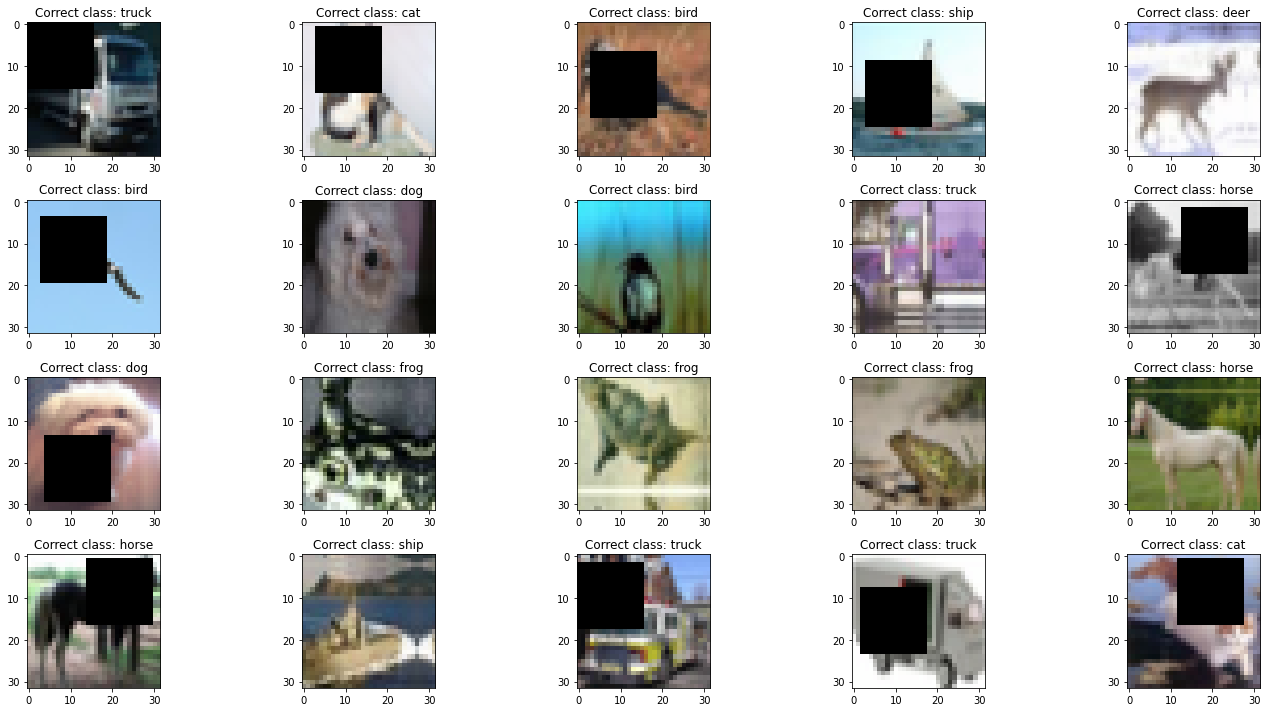

In [5]:
show_training_images(train_loader, 20, cifar10.classes)

In [6]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=20)

trainer = get_train_runner(model, train_loader, optimizer, criterion, device)
tester = get_test_runner(model, test_loader, criterion, device)

In [7]:
train_model(trainer, tester, epochs=20, scheduler=scheduler)

EPOCH = 0 | LR = 0.0040000000000000036 | Loss = 1.70 | Batch = 781 | Accuracy = 42.75: 100%|██████████| 782/782 [00:48<00:00, 16.23it/s]


Test set: Average loss: 0.0183, Accuracy: 5839/10000 (58.39%)



EPOCH = 1 | LR = 0.004000010764159012 | Loss = 1.21 | Batch = 781 | Accuracy = 60.06: 100%|██████████| 782/782 [00:48<00:00, 16.27it/s]


Test set: Average loss: 0.0158, Accuracy: 6536/10000 (65.36%)



EPOCH = 2 | LR = 0.00400004305663125 | Loss = 0.57 | Batch = 781 | Accuracy = 68.78: 100%|██████████| 782/782 [00:47<00:00, 16.33it/s]


Test set: Average loss: 0.0109, Accuracy: 7549/10000 (75.49%)



EPOCH = 3 | LR = 0.004000096877402215 | Loss = 1.08 | Batch = 781 | Accuracy = 72.90: 100%|██████████| 782/782 [00:47<00:00, 16.31it/s]


Test set: Average loss: 0.0104, Accuracy: 7717/10000 (77.17%)



EPOCH = 4 | LR = 0.004000172226447746 | Loss = 0.85 | Batch = 781 | Accuracy = 76.32: 100%|██████████| 782/782 [00:47<00:00, 16.32it/s]


Test set: Average loss: 0.0089, Accuracy: 8052/10000 (80.52%)



EPOCH = 5 | LR = 0.0040002691037340915 | Loss = 0.63 | Batch = 781 | Accuracy = 78.66: 100%|██████████| 782/782 [00:47<00:00, 16.30it/s]


Test set: Average loss: 0.0087, Accuracy: 8150/10000 (81.50%)



EPOCH = 6 | LR = 0.004000387509217759 | Loss = 0.59 | Batch = 781 | Accuracy = 80.11: 100%|██████████| 782/782 [00:47<00:00, 16.32it/s]


Test set: Average loss: 0.0082, Accuracy: 8203/10000 (82.03%)



EPOCH = 7 | LR = 0.004000527442845694 | Loss = 0.26 | Batch = 781 | Accuracy = 81.81: 100%|██████████| 782/782 [00:47<00:00, 16.31it/s]


Test set: Average loss: 0.0068, Accuracy: 8532/10000 (85.32%)



EPOCH = 8 | LR = 0.004000688904555086 | Loss = 0.64 | Batch = 781 | Accuracy = 83.25: 100%|██████████| 782/782 [00:47<00:00, 16.31it/s]


Test set: Average loss: 0.0070, Accuracy: 8482/10000 (84.82%)



EPOCH = 9 | LR = 0.004000871894273547 | Loss = 0.69 | Batch = 781 | Accuracy = 84.35: 100%|██████████| 782/782 [00:47<00:00, 16.31it/s]


Test set: Average loss: 0.0070, Accuracy: 8550/10000 (85.50%)



EPOCH = 10 | LR = 0.004001076411918977 | Loss = 0.29 | Batch = 781 | Accuracy = 85.55: 100%|██████████| 782/782 [00:47<00:00, 16.32it/s]


Test set: Average loss: 0.0066, Accuracy: 8636/10000 (86.36%)



EPOCH = 11 | LR = 0.004001302457399672 | Loss = 0.54 | Batch = 781 | Accuracy = 86.24: 100%|██████████| 782/782 [00:47<00:00, 16.31it/s]


Test set: Average loss: 0.0068, Accuracy: 8594/10000 (85.94%)



EPOCH = 12 | LR = 0.004001550030614254 | Loss = 0.23 | Batch = 781 | Accuracy = 87.52: 100%|██████████| 782/782 [00:47<00:00, 16.31it/s]


Test set: Average loss: 0.0058, Accuracy: 8774/10000 (87.74%)



EPOCH = 13 | LR = 0.004001819131451659 | Loss = 0.19 | Batch = 781 | Accuracy = 87.96: 100%|██████████| 782/782 [00:47<00:00, 16.32it/s]


Test set: Average loss: 0.0061, Accuracy: 8758/10000 (87.58%)



EPOCH = 14 | LR = 0.004002109759791234 | Loss = 0.43 | Batch = 781 | Accuracy = 88.61: 100%|██████████| 782/782 [00:47<00:00, 16.33it/s]


Test set: Average loss: 0.0062, Accuracy: 8724/10000 (87.24%)



EPOCH = 15 | LR = 0.004002421915502596 | Loss = 0.22 | Batch = 781 | Accuracy = 89.38: 100%|██████████| 782/782 [00:47<00:00, 16.30it/s]


Test set: Average loss: 0.0061, Accuracy: 8752/10000 (87.52%)



EPOCH = 16 | LR = 0.004002755598445748 | Loss = 0.56 | Batch = 781 | Accuracy = 89.91: 100%|██████████| 782/782 [00:47<00:00, 16.32it/s]


Test set: Average loss: 0.0056, Accuracy: 8809/10000 (88.09%)



EPOCH = 17 | LR = 0.00400311080847103 | Loss = 0.52 | Batch = 781 | Accuracy = 90.72: 100%|██████████| 782/782 [00:47<00:00, 16.29it/s]


Test set: Average loss: 0.0057, Accuracy: 8876/10000 (88.76%)



EPOCH = 18 | LR = 0.00400348754541914 | Loss = 0.37 | Batch = 781 | Accuracy = 90.84: 100%|██████████| 782/782 [00:47<00:00, 16.32it/s]


Test set: Average loss: 0.0059, Accuracy: 8794/10000 (87.94%)



EPOCH = 19 | LR = 0.004003885809121088 | Loss = 0.20 | Batch = 781 | Accuracy = 91.55: 100%|██████████| 782/782 [00:48<00:00, 16.29it/s]


Test set: Average loss: 0.0065, Accuracy: 8726/10000 (87.26%)



# Get misclassified images from Tester

In [8]:
misclassified_images, predictions, labels = tester.get_misclassified_images()

# Show misclassified images

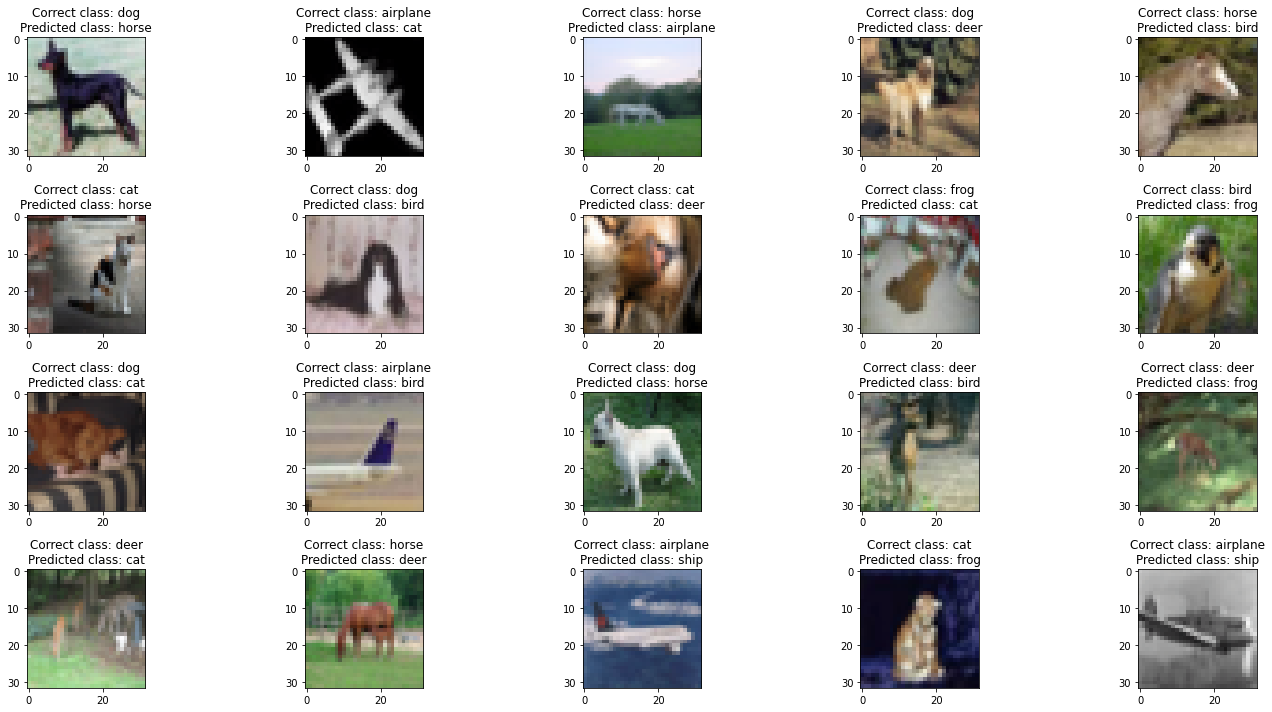

In [9]:
show_misclassified_images(misclassified_images[:20], predictions[:20], labels[:20], cifar10.classes)

# Grad-CAM of misclassified images for correct labels

_This is what model sees for correct labels but it was not enough for correct prediction._

- ## Layer 3

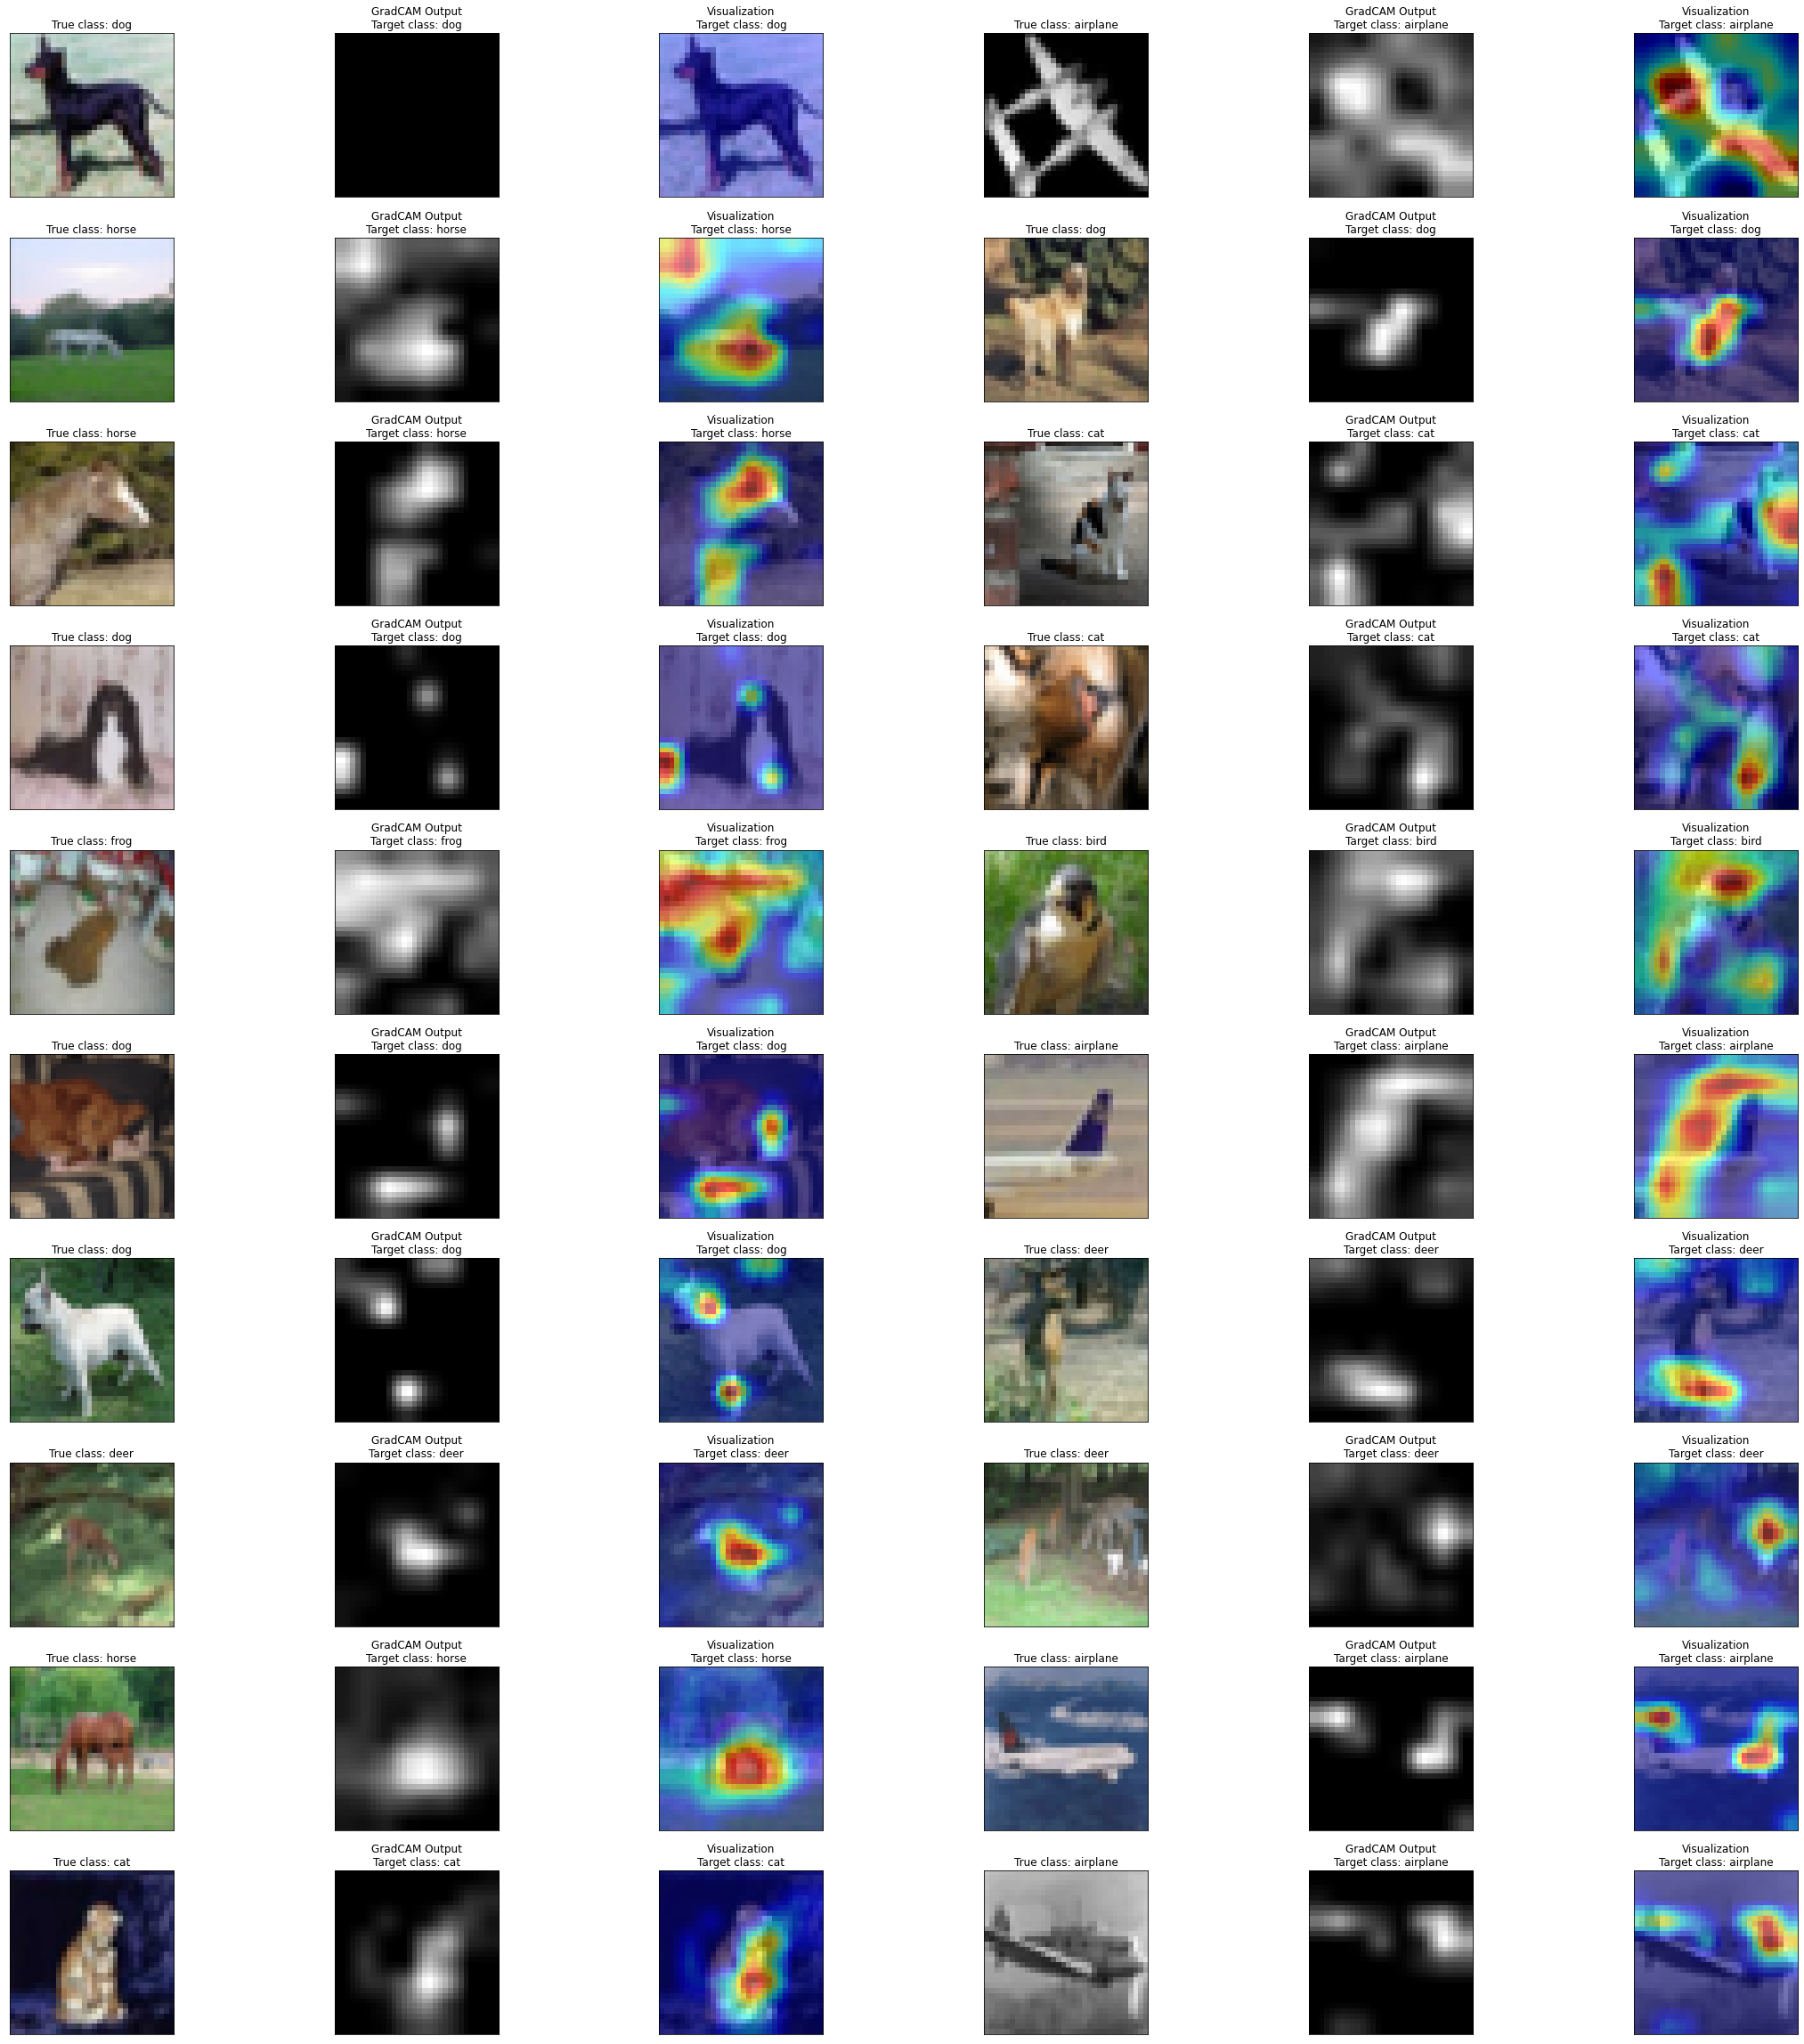

In [10]:
show_grad_cam(model, device, misclassified_images[:20], labels[:20], labels[:20], "layer3.1.conv2", cifar10.classes)

- ## Layer 4

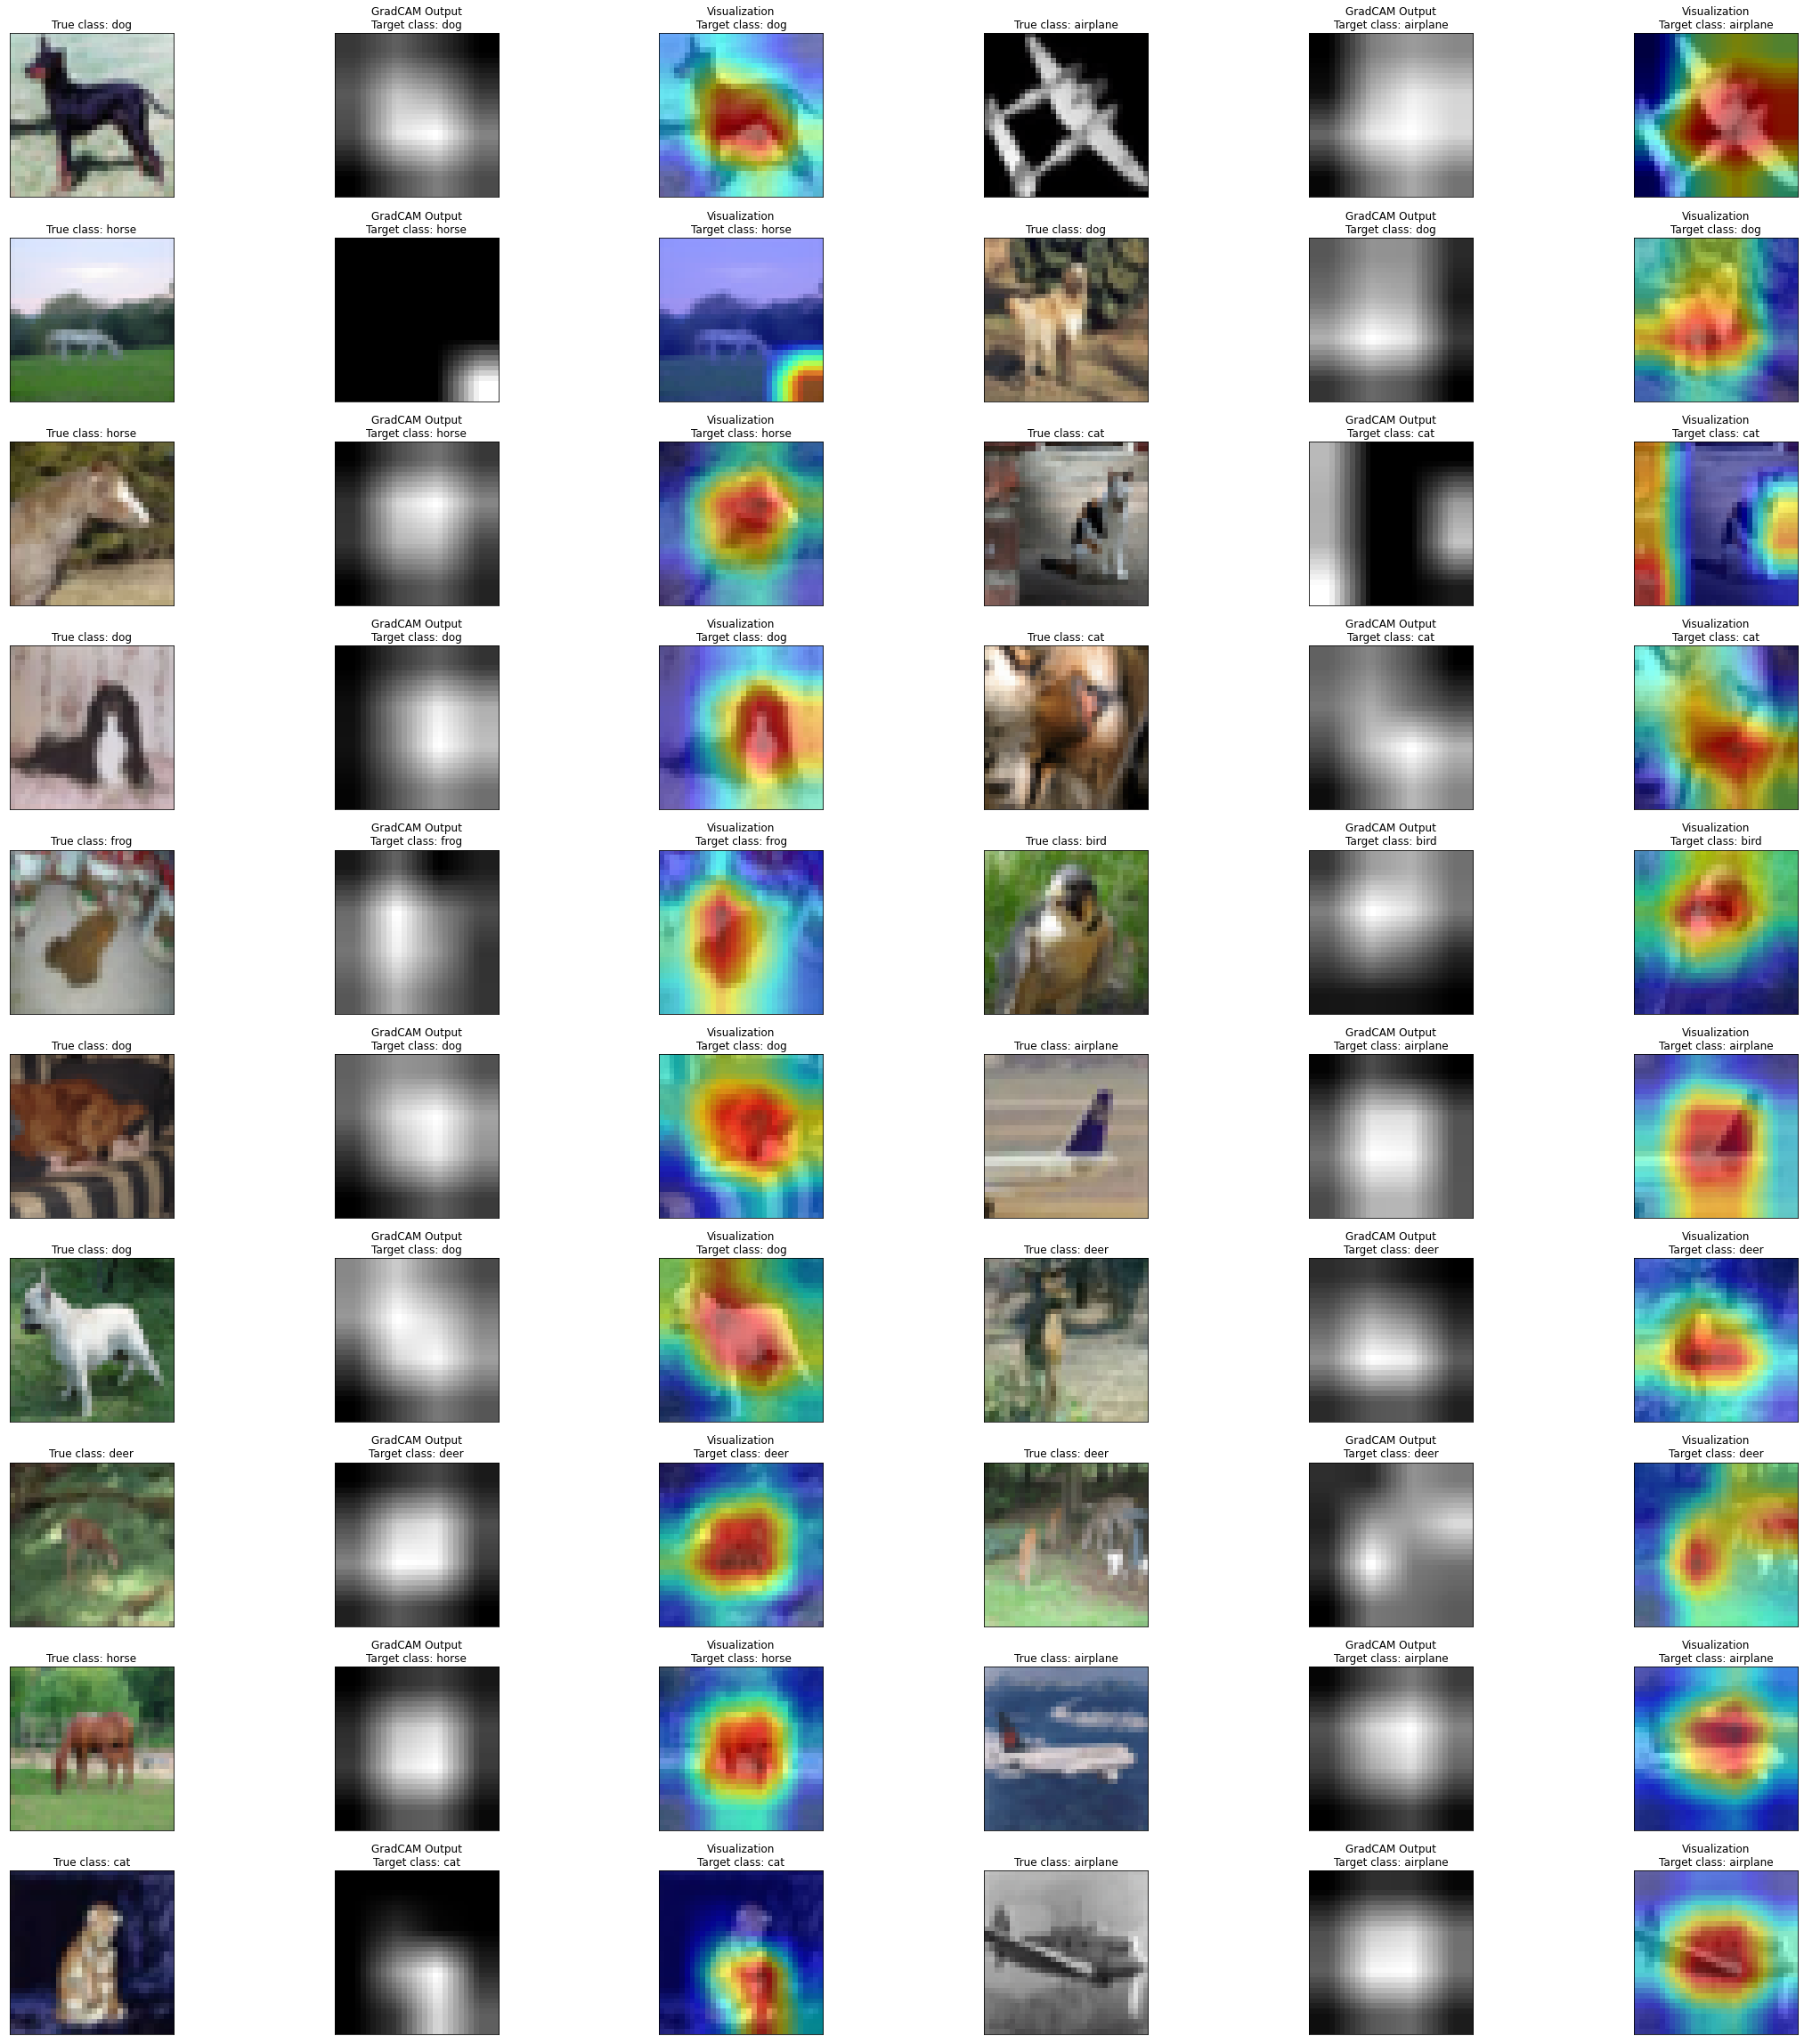

In [11]:
show_grad_cam(model, device, misclassified_images[:20], labels[:20], labels[:20], "layer4.1.conv2", cifar10.classes)

# Grad-CAM of misclassified images for predictions

_This is what model sees that it based its prediction on._

- ## Layer 3

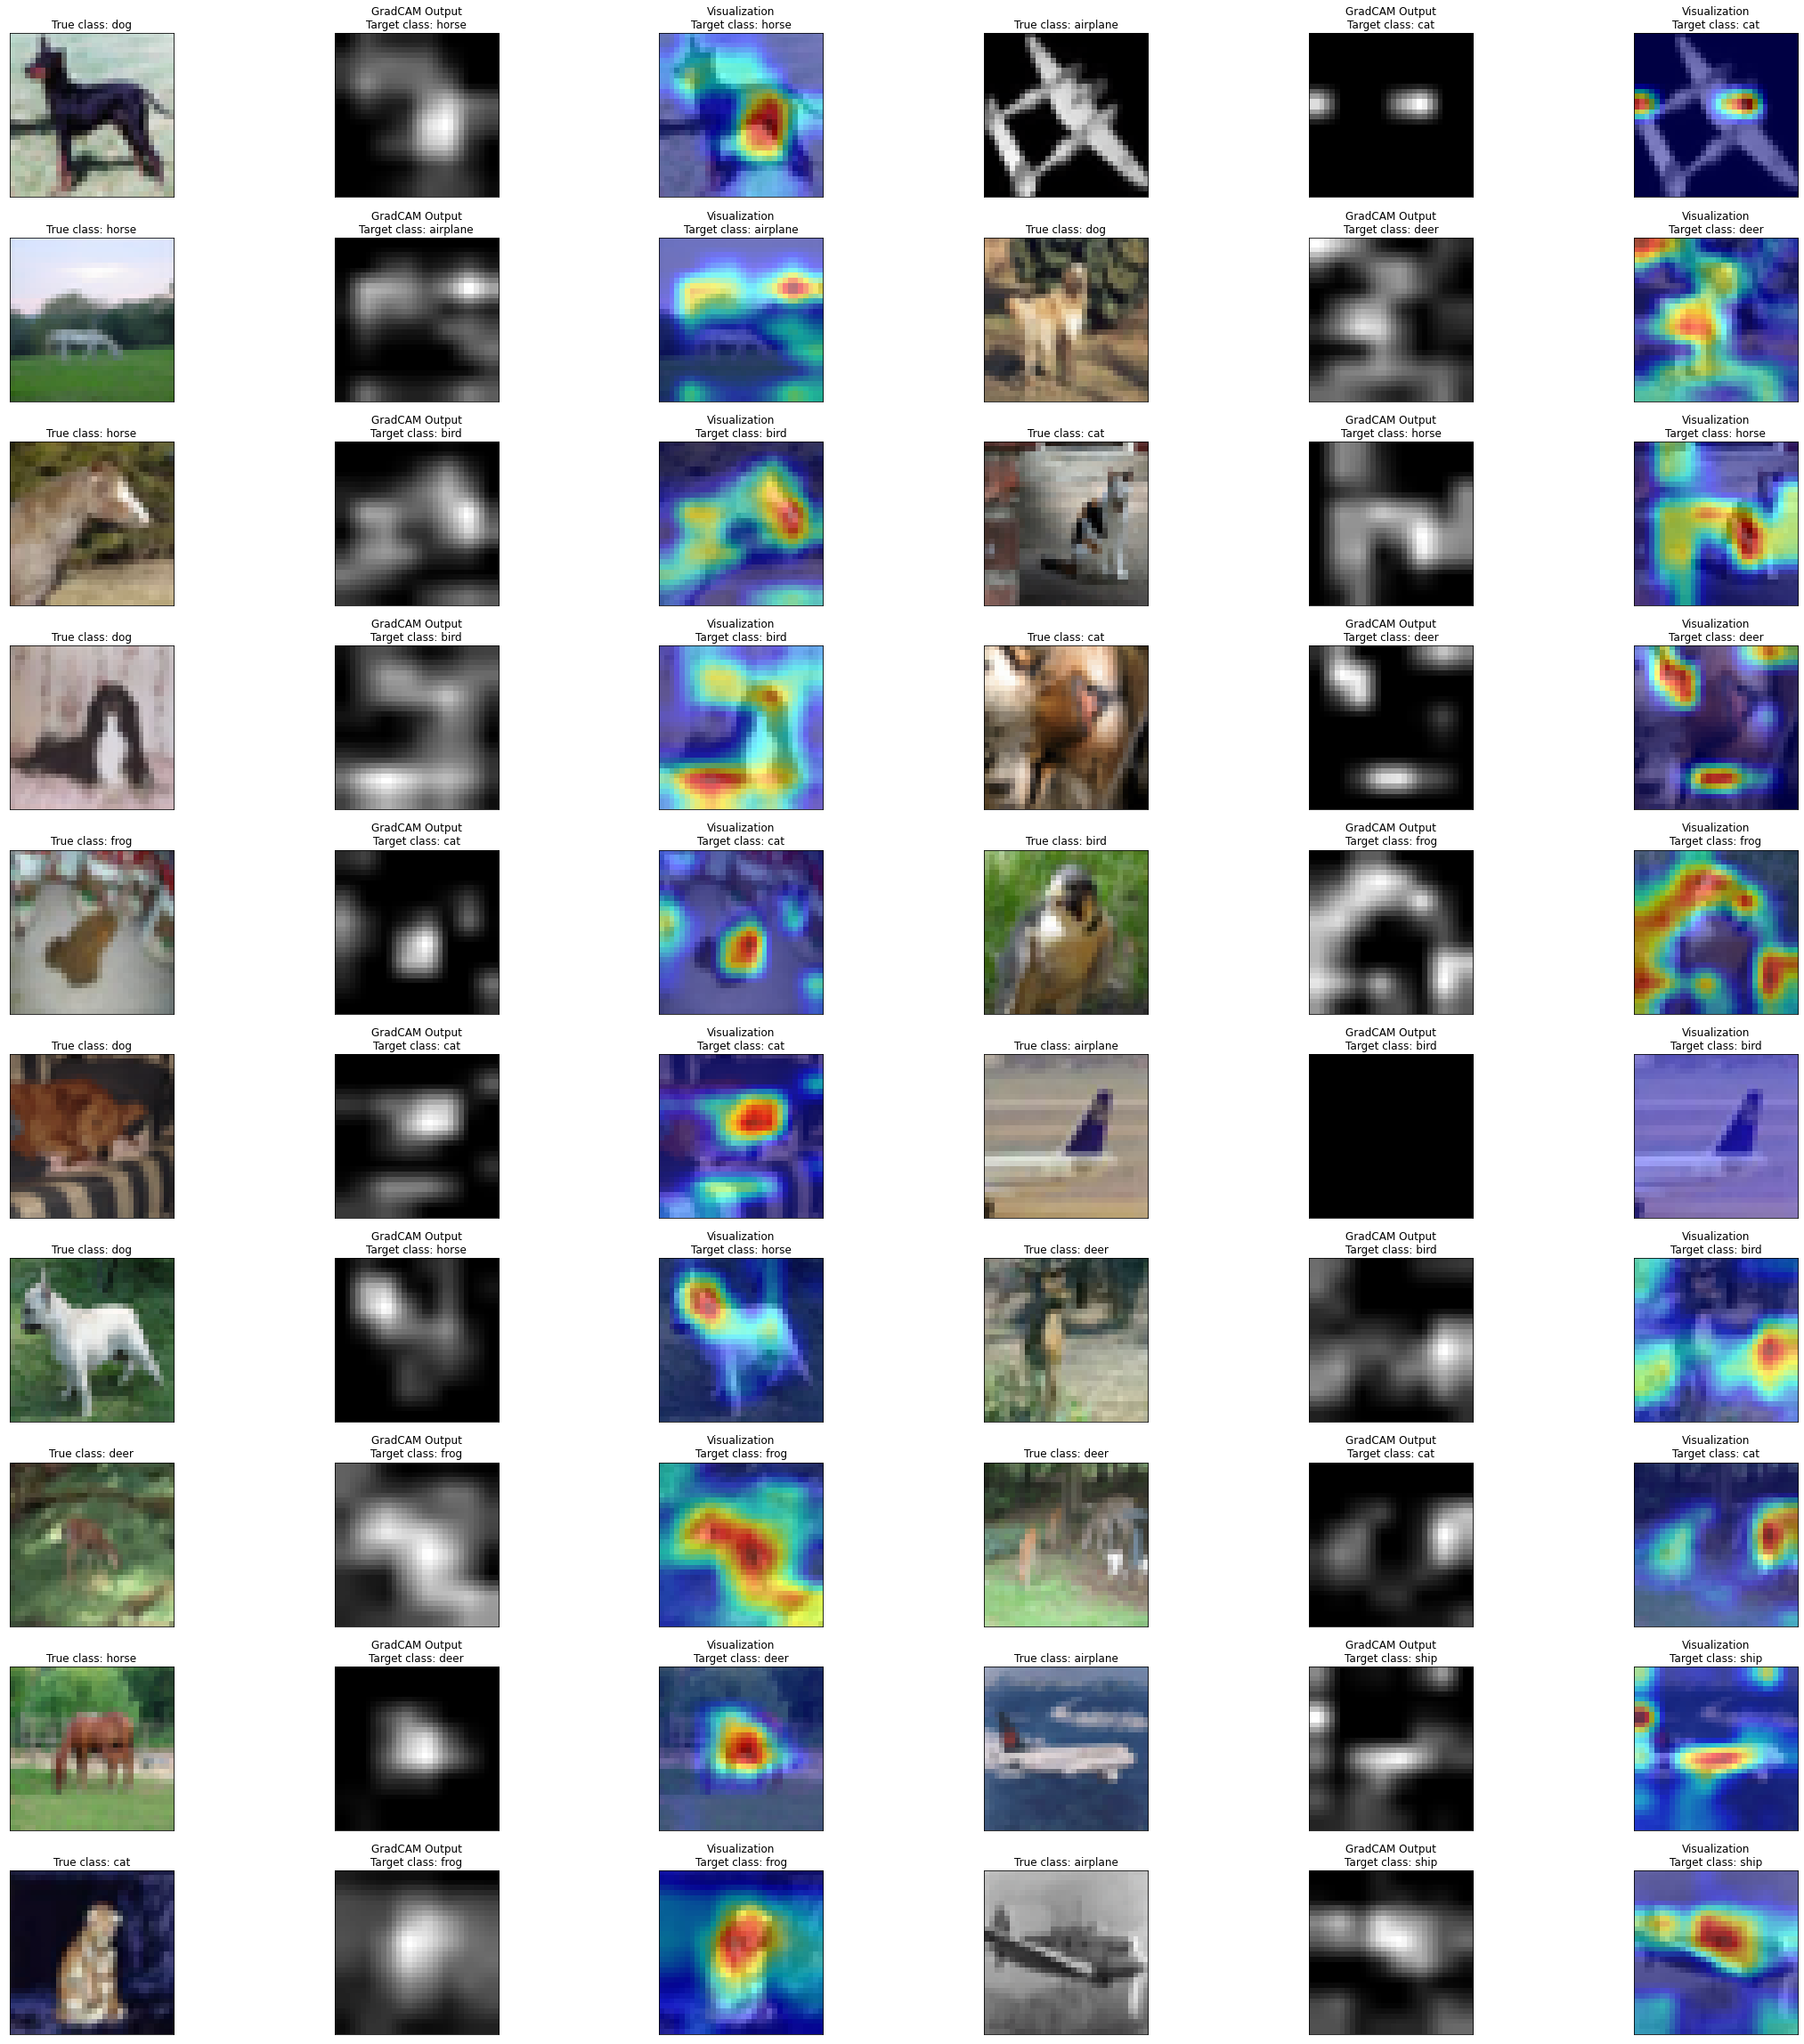

In [12]:
show_grad_cam(model, device, misclassified_images[:20], labels[:20], predictions[:20], "layer3.1.conv2", cifar10.classes)

- ## Layer 4

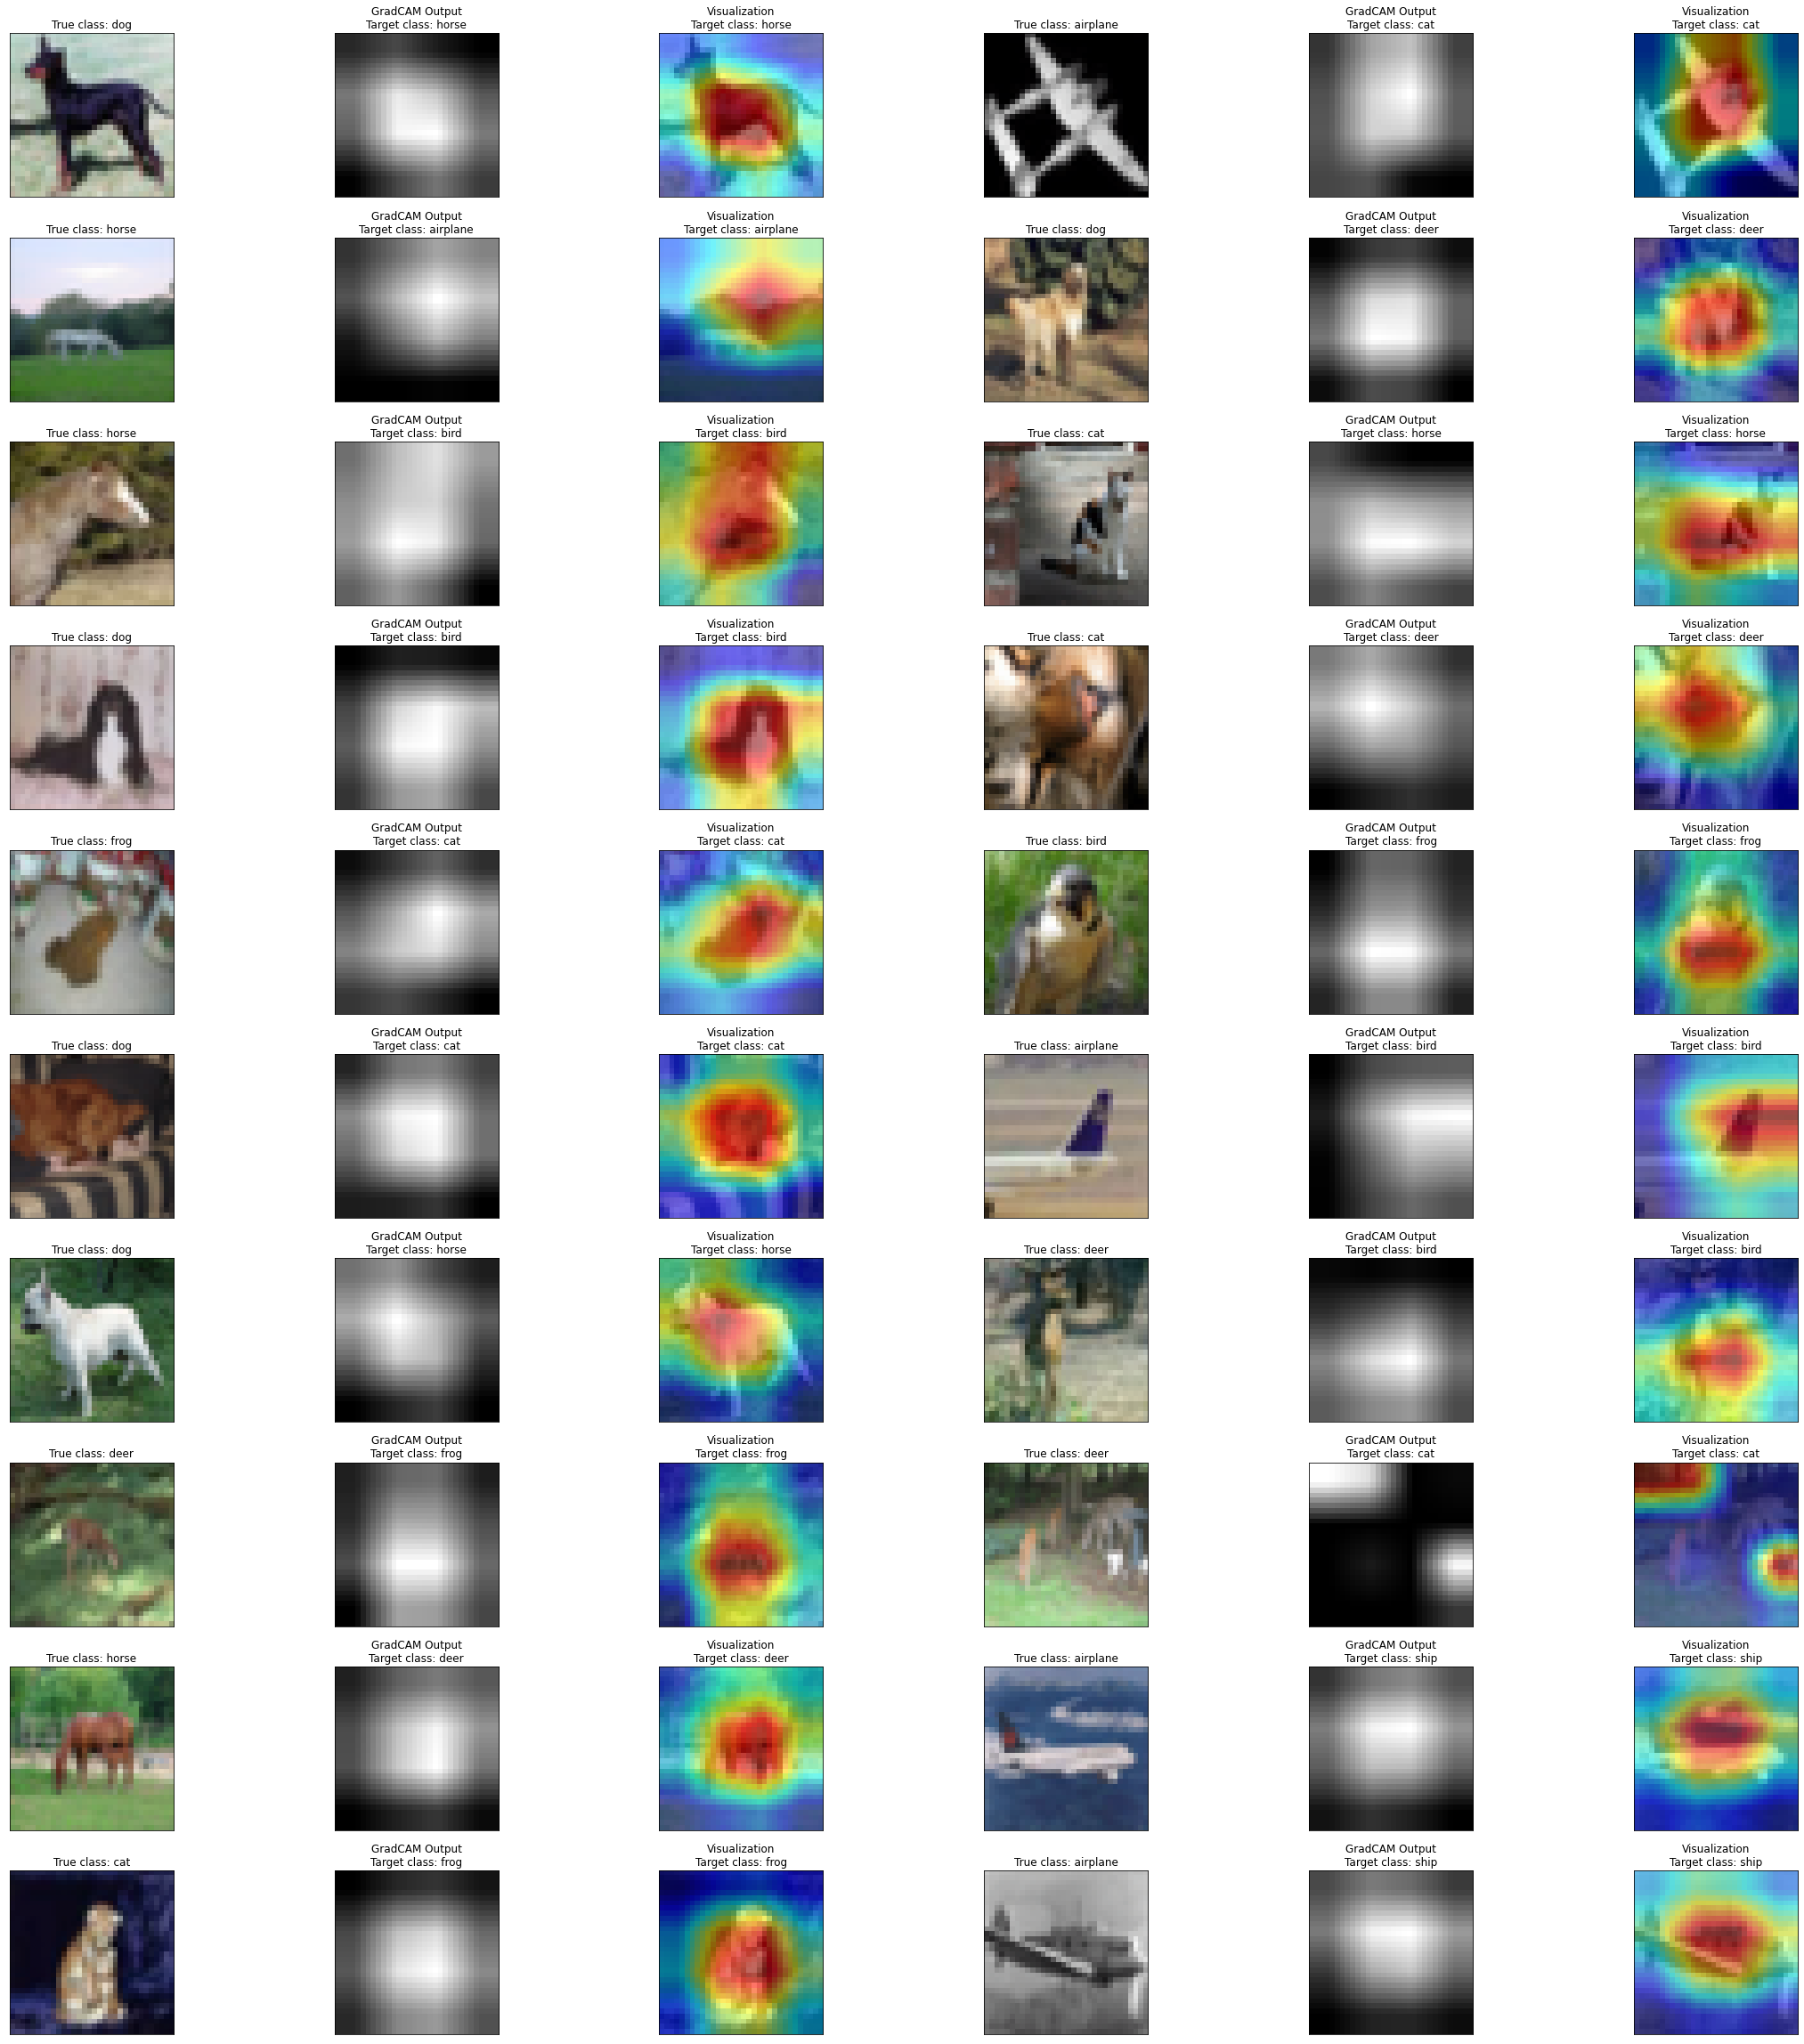

In [13]:
show_grad_cam(model, device, misclassified_images[:20], labels[:20], predictions[:20], "layer4.1.conv2", cifar10.classes)

# Loss and Accuracy Graphs for Training and Testing

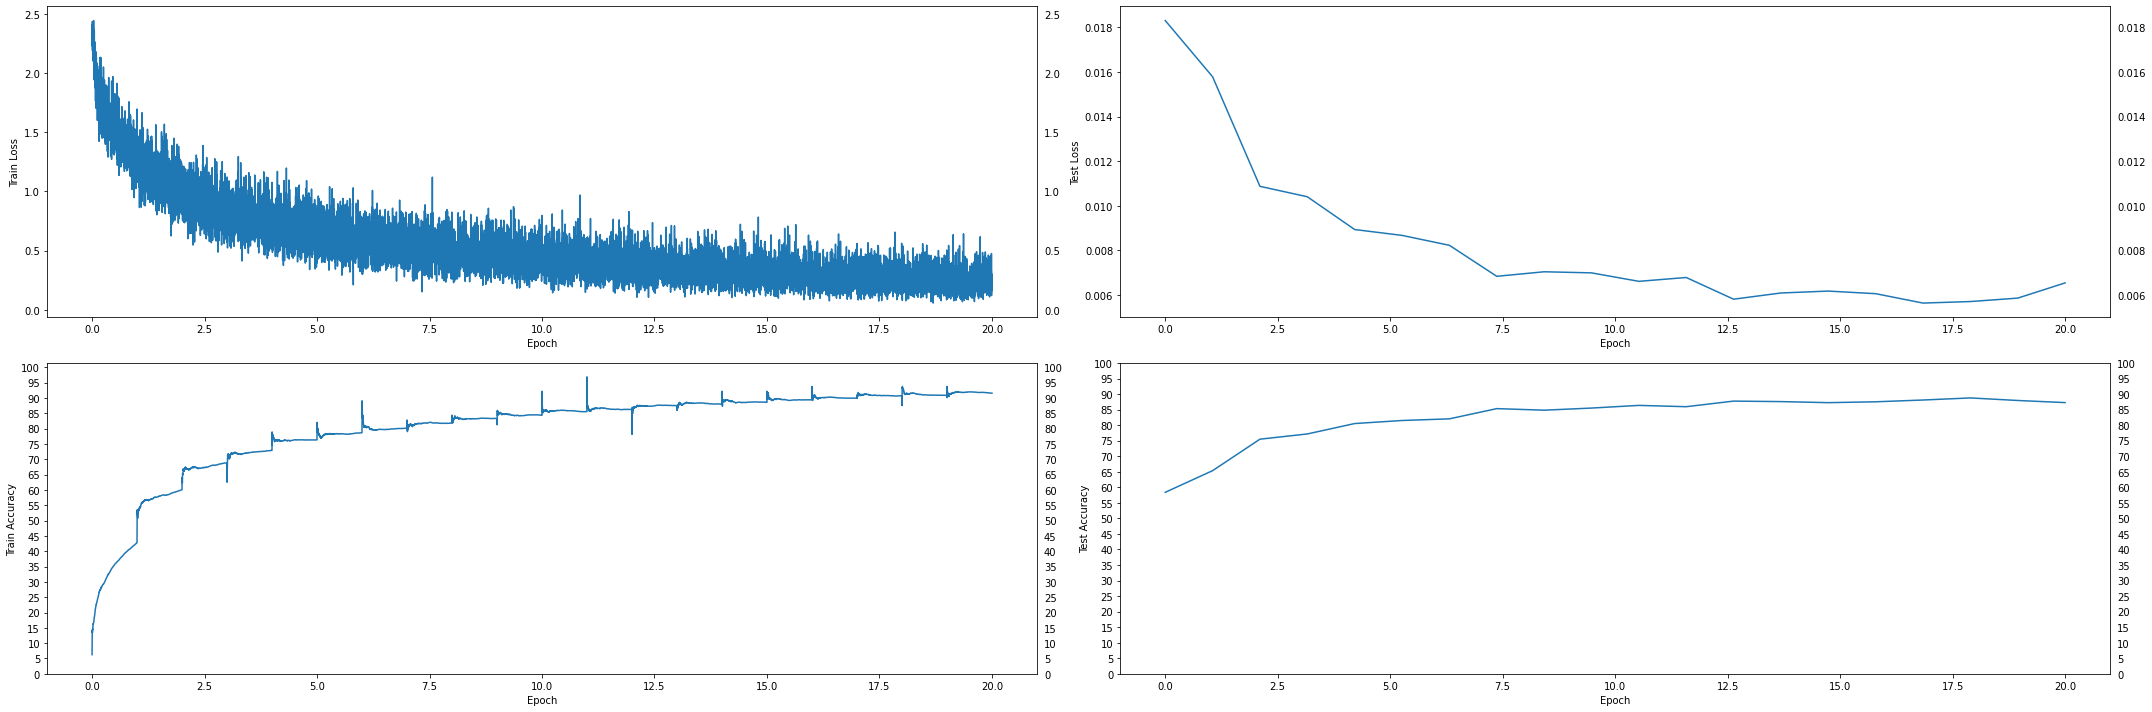

In [14]:
show_losses_and_accuracies(trainer, tester, 20)